In [ ]:
!pip install -U numpyro --quiet;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2200.164
cache size	: 56320 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4400.32
clflush size	: 64
cache_alignment	: 64
addres

In [ ]:
import numpyro
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
from functools import partial

from jax import jit, vmap
import jax.numpy as jnp
from jax import random

import matplotlib.pyplot as plt
import time

In [ ]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [ ]:
key = random.PRNGKey(1)

In [ ]:
def misspecification_transform(x, misspec_level=1.0, key=None):
    misspec_x = x + 100 * dist.Normal(0, 1).sample(key, sample_shape=(10,)) * misspec_level * jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0])
    return misspec_x

In [ ]:
def true_dgp(t1, t2, t3, t4, t5, batch_size=1, key=None):
  m_theta = jnp.array([t1, t2])
  s1 = t3 ** 2
  s2 = t4 ** 2
  rho = jnp.tanh(t5)
  cov_mat = jnp.array([[s1 ** 2, rho * s1 * s2], [rho * s1 * s2, s2 ** 2]])
  y = dist.MultivariateNormal(m_theta, cov_mat).sample(key=key, sample_shape=((batch_size, 5)))  # TODO: CHANGED TO 5

  return y.reshape(batch_size, -1)

In [ ]:
def assumed_dgp(t1, t2, t3, t4, t5, std_err=1.0, batch_size=1, key=None):
  x = true_dgp(t1, t2, t3, t4, t5, batch_size, key)
  return x

In [ ]:
def summ_stats(x):
  return x

In [ ]:
def simulation_wrapper(params, batch_size=1, key=None):
  x_sim = assumed_dgp(*params, batch_size=batch_size, key=key)
  sim_sum = summ_stats(x_sim)
  return sim_sum.reshape((batch_size, -1))

In [ ]:
key, subkey = random.split(key)
true_params = jnp.array([0.7, -2.9, -1.0, -0.9, 0.6])

In [ ]:
key, subkey1, subkey2 = random.split(key, 3)
x_obs = misspecification_transform(jnp.squeeze(summ_stats(true_dgp(*true_params, key=subkey1))), key=subkey2)
x_obs = jnp.squeeze(x_obs)

In [ ]:
x_obs

DeviceArray([   0.51417744,   -2.1834092 ,    2.279926  ,   -1.3189619 ,
                2.8727434 ,   -3.3031068 ,    1.5085756 ,   -3.9590554 ,
             -172.70644   ,  -79.922035  ], dtype=float32)

In [ ]:
summary_dims = len(x_obs)

In [ ]:
prior = dist.Uniform(low=jnp.repeat(-3.0, 5), high=jnp.repeat(3.0, 5))

In [ ]:
prior.log_prob(prior.sample(key))

DeviceArray([-1.7917595, -1.7917595, -1.7917595, -1.7917595, -1.7917595],            dtype=float32, weak_type=True)

In [ ]:
!pip install -U flowjax==7.0.0 --quiet;

In [ ]:
from flowjax.flows import CouplingFlow
from flowjax.bijections import RationalQuadraticSpline
from flowjax.distributions import StandardNormal
from flowjax.train_utils import train_flow

In [ ]:
from numpyro.distributions.util import validate_sample
class FlowNumpyro(dist.Distribution):
    def __init__(self, flow=None, theta=None):
        self.flow = flow
        self.theta = theta
        super(FlowNumpyro, self).__init__()
        
    def sample(self, num_samples=1):
        return self.flow.sample(num_samples)

    @validate_sample
    def log_prob(self, value):
        ll = self.flow.log_prob(value, condition=self.theta)
        return ll

In [ ]:
def model(x_obs_standard, prior, density_estimator, laplace_var=None, standardisation_params=None, key=None):
    theta = numpyro.sample('theta', prior)
    theta_dims = len(standardisation_params['theta_mean'])
    summary_dims = len(x_obs_standard)
    laplace_mean = jnp.zeros(summary_dims)
    if laplace_var is None:
        laplace_var = jnp.ones(summary_dims)

    theta_standard = numpyro.deterministic('theta_standard', (theta - standardisation_params['theta_mean']) / standardisation_params['theta_std'])
    adj_params = numpyro.sample('adj_params', dist.Laplace(laplace_mean, laplace_var))
    x_adj = numpyro.deterministic('x_adj',  x_obs_standard - adj_params)
    if density_estimator is not None:  # TODO?
        x_adj_sample = numpyro.sample('x_adj_sample', FlowNumpyro(density_estimator, theta=theta_standard), obs=x_adj)
    else:
        x_adj_sample = x_adj
    return x_adj_sample

In [ ]:
@jit
def generate_simulations(theta, key):
    x_sim = simulation_wrapper(theta, key=key) 
    return x_sim

generate_simulations_vmap = vmap(generate_simulations, in_axes=(0, 0))

In [ ]:
tic = time.time()

In [ ]:
num_rounds = 10
num_sims_per_round = 1000
thinning = 10
num_warmup = 1000
num_chains = 4
theta_dims = len(true_params)
summary_dims = len(x_obs)

x_sims_all = jnp.empty((0, summary_dims))
thetas_all = jnp.empty((0, theta_dims))

flow = None

init_params = {
    'theta': jnp.tile(true_params, num_chains).reshape((num_chains, -1)),
    'adj_params': jnp.tile(jnp.zeros(summary_dims), num_chains).reshape((num_chains, -1))
    }

x_obs_standard = x_obs

standardisation_params = {
    'theta_mean': jnp.empty(theta_dims),
    'theta_std': jnp.empty(theta_dims),
    'x_sims_mean': jnp.empty(summary_dims),
    'x_sims_std': jnp.empty(summary_dims)
}

for i in range(num_rounds):
    nuts_kernel = NUTS(model,
                    #    dense_mass=True,
                       target_accept_prob=0.95)  # INCREASED FOR ROBUSTNESS
    mcmc = MCMC(nuts_kernel,
                num_warmup=num_warmup,
                num_samples=round((num_sims_per_round*thinning)/num_chains),
                thinning=thinning,
                num_chains=num_chains)
    key, subkey1, subkey2 = random.split(key, 3)
    laplace_var = 0.3 * jnp.abs(x_obs_standard)  # TODO: In testing...
    mcmc.run(subkey1,
             x_obs_standard,
             prior=prior,
             density_estimator=flow, 
             laplace_var=laplace_var,
             standardisation_params=standardisation_params,
             key=subkey2,
             init_params=init_params
             )
    mcmc.print_summary()  
    # set init_params for next round MCMC to final round vals
    key, subkey = random.split(key)
    rand_idx = random.randint(subkey, (num_chains,), 0, num_sims_per_round)
    for k,_ in init_params.items():
        # for chain_num in range(num_chains):
        init_params[k] = mcmc.get_samples()[k][-rand_idx]
    print('init_params: ', init_params)
    thetas = mcmc.get_samples()['theta']

    sim_keys = random.split(key, len(thetas))
    x_sims = jnp.squeeze(generate_simulations_vmap(thetas, sim_keys))

    x_sims_all = jnp.append(x_sims_all, x_sims.reshape(-1, summary_dims), axis=0)
    thetas_all = jnp.append(thetas_all, thetas.reshape(-1, theta_dims), axis=0)

    # standardise simulated summaries
    standardisation_params['x_sims_mean'] = jnp.mean(x_sims_all, axis=0)
    standardisation_params['x_sims_std'] = jnp.std(x_sims_all, axis=0)
    x_sims_all_standardised = (x_sims_all - standardisation_params['x_sims_mean'] ) / standardisation_params['x_sims_std']
    x_obs_standard = (x_obs - standardisation_params['x_sims_mean']) / standardisation_params['x_sims_std']

    # standardise parameters
    standardisation_params['theta_mean'] = jnp.mean(thetas_all, axis=0)
    standardisation_params['theta_std'] = jnp.std(thetas_all, axis=0)
    print('standardisation_params: ', standardisation_params)
    print('x_obs_standard: ', x_obs_standard)

    thetas_all_standardised = (thetas_all - standardisation_params['theta_mean']) / standardisation_params['theta_std']

    key, subkey = random.split(key)
    flow = CouplingFlow(
        key=subkey,
        base_dist=StandardNormal((10,)),
        transformer=RationalQuadraticSpline(knots=10, interval=5), # 10 spline segments over [-B, B].  # TODO? Increase num segments?
        cond_dim=thetas_all_standardised.shape[1],
        flow_layers=5,
        nn_width=50
        )

    key, subkey = random.split(key)
    flow, losses = train_flow(subkey, flow, x_sims_all_standardised, thetas_all_standardised, max_epochs=500)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]      0.00      0.22     -0.00     -0.33      0.37   1074.50      1.00
adj_params[1]     -0.05      0.97     -0.02     -1.56      1.51   1025.05      1.00
adj_params[2]      0.02      0.93      0.02     -1.46      1.47    860.62      1.00
adj_params[3]      0.01      0.56     -0.01     -0.90      0.92    920.26      1.00
adj_params[4]      0.04      1.24      0.02     -1.78      2.13    970.79      1.00
adj_params[5]      0.05      1.54      0.00     -2.27      2.45    981.60      1.00
adj_params[6]     -0.00      0.64     -0.01     -1.03      1.00    985.99      1.00
adj_params[7]      0.07      1.63      0.05     -2.48      2.75   1036.56      1.00
adj_params[8]      2.16     77.02      2.82   -114.29    136.10    997.63      1.00
adj_params[9]     -0.05     32.33      0.12    -55.31     50.81   1008.44      1.00
     theta[0]      0.10      1.74      0.14     -2.78      2.61   1010.20  

100%|██████████| 500/500 [00:55<00:00,  9.04it/s, train=2.78, val=0]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.01      0.03     -0.00     -0.04      0.02     42.21      1.11
adj_params[1]     -0.33      0.30     -0.35     -0.80     -0.01      2.25      3.18
adj_params[2]      0.53      0.45      0.84      0.00      1.09      2.06      5.91
adj_params[3]     -0.18      0.14     -0.27     -0.37      0.02      2.52      2.31
adj_params[4]     -0.09      0.95      0.06     -1.62      0.99      2.03     10.55
adj_params[5]     -1.08      0.58     -1.33     -1.77     -0.13      2.17      3.67
adj_params[6]      0.15      0.18      0.08      0.00      0.46      2.07      6.05
adj_params[7]      0.06      0.35     -0.02     -0.35      0.57      2.76      2.00
adj_params[8]    -20.67     13.05    -20.24    -40.40     -3.00      2.01     33.19
adj_params[9]     -7.00      7.09     -3.37    -19.17     -2.01      2.01     20.29
     theta[0]     -0.74      1.76     -1.68     -2.71      1.26      2.12  

100%|██████████| 500/500 [01:51<00:00,  4.46it/s, train=1.52, val=0]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.01      0.06     -0.01     -0.09      0.09     33.42      1.10
adj_params[1]      0.06      0.12      0.07     -0.10      0.22      4.89      1.38
adj_params[2]     -0.00      0.16     -0.04     -0.17      0.30     11.39      1.23
adj_params[3]     -0.02      0.12      0.03     -0.21      0.09      2.60      2.12
adj_params[4]      0.02      0.25      0.03     -0.37      0.40      3.31      1.66
adj_params[5]     -0.19      0.19     -0.13     -0.55      0.02      5.08      1.44
adj_params[6]      0.06      0.09      0.05     -0.08      0.18     40.53      1.08
adj_params[7]      0.69      1.65     -0.16     -0.47      3.55      2.02     11.03
adj_params[8]    -36.52      2.28    -35.29    -40.72    -34.97      2.03      8.93
adj_params[9]    -18.26      1.72    -17.03    -20.30    -16.14      2.10      4.64
     theta[0]      1.16      0.51      1.05      0.61      2.14      8.20  

 13%|█▎        | 66/500 [00:32<03:35,  2.01it/s, train=6.53, val=8.58 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.01      0.04     -0.01     -0.07      0.07   1047.36      1.00
adj_params[1]     -0.01      0.13     -0.01     -0.21      0.23    938.15      1.00
adj_params[2]      0.09      0.16      0.08     -0.15      0.37   1019.77      1.00
adj_params[3]      0.02      0.08      0.01     -0.11      0.16   1063.35      1.00
adj_params[4]      0.05      0.25      0.03     -0.32      0.47    917.38      1.00
adj_params[5]     -0.10      0.20     -0.08     -0.41      0.20    985.53      1.01
adj_params[6]      0.04      0.12      0.03     -0.15      0.24   1099.40      1.00
adj_params[7]     -0.17      0.26     -0.15     -0.58      0.19   1046.85      1.00
adj_params[8]    -43.78      0.56    -43.78    -44.63    -42.88    919.91      1.00
adj_params[9]    -16.92      0.71    -16.98    -17.90    -15.66   1042.16      1.00
     theta[0]      1.06      0.93      1.08     -0.01      2.69   1011.40  

 23%|██▎       | 116/500 [01:01<03:23,  1.89it/s, train=3.99, val=6.81 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.00      0.02     -0.00     -0.03      0.02   1011.41      1.00
adj_params[1]     -0.00      0.10      0.00     -0.16      0.17    803.70      1.00
adj_params[2]      0.09      0.16      0.08     -0.14      0.36   1103.87      1.00
adj_params[3]      0.01      0.05      0.01     -0.06      0.09    877.46      1.00
adj_params[4]      0.05      0.26      0.03     -0.36      0.44    963.34      1.00
adj_params[5]     -0.13      0.21     -0.12     -0.46      0.20    844.54      1.00
adj_params[6]      0.02      0.12      0.01     -0.12      0.26   1187.87      1.00
adj_params[7]     -0.20      0.24     -0.19     -0.60      0.15   1016.55      1.00
adj_params[8]    -44.63      0.57    -44.64    -45.36    -43.58   1007.14      1.00
adj_params[9]    -17.53      0.52    -17.54    -18.30    -16.72    930.56      1.00
     theta[0]      1.18      0.81      1.25      0.00      2.28    786.44  

 22%|██▏       | 109/500 [01:07<04:00,  1.63it/s, train=3, val=4.27 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.00      0.00     -0.00     -0.01      0.01    950.26      1.00
adj_params[1]     -0.01      0.10     -0.01     -0.19      0.14    882.88      1.00
adj_params[2]      0.09      0.18      0.06     -0.16      0.40    961.18      1.00
adj_params[3]      0.00      0.02      0.00     -0.03      0.04   1009.06      1.00
adj_params[4]      0.17      0.24      0.17     -0.18      0.59    943.34      1.00
adj_params[5]     -0.16      0.19     -0.15     -0.47      0.12    931.59      1.00
adj_params[6]      0.01      0.11      0.01     -0.16      0.18   1108.72      1.00
adj_params[7]     -0.28      0.24     -0.29     -0.63      0.09    900.81      1.00
adj_params[8]    -47.55      0.57    -47.56    -48.29    -46.63    765.45      1.00
adj_params[9]    -18.46      0.60    -18.51    -19.31    -17.46    952.71      1.00
     theta[0]      1.32      0.90      1.37      0.32      2.90    889.45  

 30%|██▉       | 148/500 [01:43<04:05,  1.43it/s, train=1.29, val=3 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.00      0.02     -0.00     -0.03      0.02    212.73      1.01
adj_params[1]     -0.01      0.09     -0.01     -0.17      0.13     99.46      1.04
adj_params[2]      0.05      0.17      0.03     -0.17      0.36    137.86      1.02
adj_params[3]     -0.00      0.01     -0.00     -0.01      0.01    171.32      1.01
adj_params[4]      0.11      0.25      0.08     -0.33      0.50     51.44      1.08
adj_params[5]     -0.13      0.17     -0.12     -0.43      0.14    170.56      1.02
adj_params[6]      0.00      0.08      0.00     -0.13      0.13    103.69      1.04
adj_params[7]     -0.21      0.25     -0.22     -0.62      0.12     74.31      1.06
adj_params[8]    -47.71      2.63    -47.16    -50.67    -44.72      2.06      6.77
adj_params[9]    -19.72      0.44    -19.71    -20.31    -19.09     16.04      1.11
     theta[0]      1.70      0.67      1.76      0.68      2.70    281.79  

 22%|██▏       | 110/500 [01:28<05:15,  1.24it/s, train=2.1, val=3.66 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.01      0.04     -0.00     -0.07      0.05    997.12      1.00
adj_params[1]      0.01      0.08      0.00     -0.12      0.14    889.07      1.00
adj_params[2]      0.07      0.18      0.04     -0.21      0.39   1038.77      1.00
adj_params[3]      0.00      0.01      0.00     -0.01      0.01    938.66      1.00
adj_params[4]      0.15      0.25      0.14     -0.28      0.53    974.32      1.00
adj_params[5]     -0.14      0.20     -0.13     -0.45      0.14   1026.13      1.00
adj_params[6]      0.01      0.09      0.00     -0.13      0.16   1137.98      1.00
adj_params[7]     -0.26      0.24     -0.27     -0.62      0.12    666.46      1.00
adj_params[8]    -52.36      0.61    -52.33    -53.48    -51.54   1024.92      1.00
adj_params[9]    -20.76      0.53    -20.75    -21.50    -19.91    869.16      1.00
     theta[0]      1.55      0.83      1.58      0.55      2.93    987.89  

 18%|█▊        | 91/500 [01:27<06:31,  1.04it/s, train=2.45, val=4.53 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.01      0.05     -0.00     -0.11      0.06    773.26      1.00
adj_params[1]     -0.00      0.08     -0.00     -0.12      0.13    957.38      1.00
adj_params[2]      0.05      0.16      0.03     -0.20      0.35    916.80      1.00
adj_params[3]      0.00      0.02      0.00     -0.03      0.03    994.73      1.00
adj_params[4]      0.16      0.25      0.12     -0.24      0.55   1001.61      1.00
adj_params[5]     -0.09      0.19     -0.07     -0.39      0.21    925.52      1.00
adj_params[6]      0.00      0.08      0.00     -0.12      0.14    848.82      1.00
adj_params[7]     -0.24      0.25     -0.23     -0.65      0.12    858.73      1.00
adj_params[8]    -54.28      0.63    -54.28    -55.33    -53.34    895.05      1.00
adj_params[9]    -21.59      0.44    -21.62    -22.15    -20.75   1029.63      1.00
     theta[0]      1.29      0.92      1.33      0.25      2.84    717.34  

 22%|██▏       | 110/500 [01:50<06:31,  1.01s/it, train=1.81, val=3.37 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.02      0.07     -0.01     -0.13      0.07    930.64      1.00
adj_params[1]      0.00      0.07      0.00     -0.13      0.11   1031.88      1.00
adj_params[2]      0.07      0.18      0.04     -0.19      0.36    980.41      1.00
adj_params[3]      0.00      0.03      0.00     -0.04      0.06   1003.96      1.00
adj_params[4]      0.18      0.25      0.16     -0.17      0.62    896.79      1.00
adj_params[5]     -0.16      0.21     -0.12     -0.53      0.15    905.09      1.00
adj_params[6]      0.01      0.08      0.00     -0.11      0.14   1020.72      1.00
adj_params[7]     -0.25      0.26     -0.23     -0.71      0.10    828.49      1.00
adj_params[8]    -56.14      0.67    -56.18    -57.10    -55.18    966.05      1.00
adj_params[9]    -22.66      0.62    -22.65    -23.65    -21.88    759.44      1.00
     theta[0]      1.52      0.79      1.59      0.48      2.83    989.93  

 18%|█▊        | 92/500 [01:45<07:47,  1.14s/it, train=2.08, val=3.37 (Max patience reached)]


In [ ]:
mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.02      0.07     -0.01     -0.13      0.07    930.64      1.00
adj_params[1]      0.00      0.07      0.00     -0.13      0.11   1031.88      1.00
adj_params[2]      0.07      0.18      0.04     -0.19      0.36    980.41      1.00
adj_params[3]      0.00      0.03      0.00     -0.04      0.06   1003.96      1.00
adj_params[4]      0.18      0.25      0.16     -0.17      0.62    896.79      1.00
adj_params[5]     -0.16      0.21     -0.12     -0.53      0.15    905.09      1.00
adj_params[6]      0.01      0.08      0.00     -0.11      0.14   1020.72      1.00
adj_params[7]     -0.25      0.26     -0.23     -0.71      0.10    828.49      1.00
adj_params[8]    -56.14      0.67    -56.18    -57.10    -55.18    966.05      1.00
adj_params[9]    -22.66      0.62    -22.65    -23.65    -21.88    759.44      1.00
     theta[0]      1.52      0.79      1.59      0.48      2.83    989.93  

In [ ]:
losses

{'train': [13.536362974984305,
  11.334536606924878,
  10.282676587785996,
  9.633635466439381,
  9.14301749638149,
  8.771300165993827,
  8.461380222865513,
  8.205748135702953,
  7.957910129002162,
  7.742192254747661,
  7.5456481116158605,
  7.338556385040285,
  7.13951986857823,
  6.950622953687395,
  6.753326933724538,
  6.586000783102849,
  6.362046759469168,
  6.173975004468646,
  5.965465300423758,
  5.810811247144427,
  5.64215304510934,
  5.455545657021659,
  5.291793932233538,
  5.151637635912214,
  4.991402489798409,
  4.861450903756278,
  4.758502714974539,
  4.645482226780484,
  4.513051196507044,
  4.426581886836462,
  4.343082400730678,
  4.2550833157130645,
  4.155767972128731,
  4.08161506652832,
  4.033250086648124,
  3.931839684077672,
  3.877709763390677,
  3.79306708744594,
  3.7502924919128433,
  3.704574591772897,
  3.6323457377297546,
  3.5879697867802207,
  3.534463773454939,
  3.4905518123081754,
  3.4414756502423955,
  3.373581089292253,
  3.331657818385534,

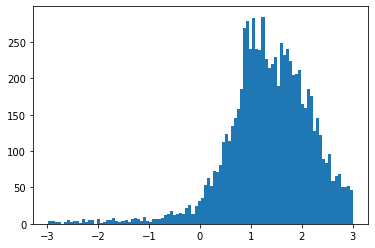

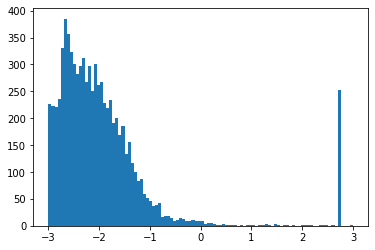

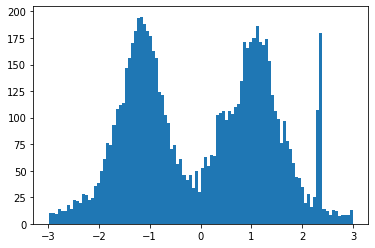

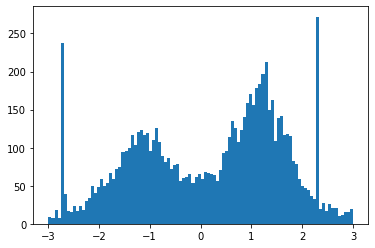

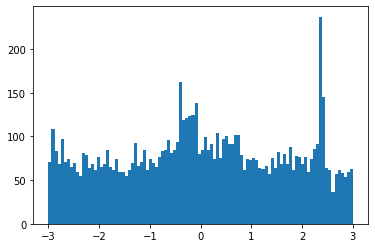

In [ ]:
for i in range(5):
    plt.hist(thetas_all[2000:, i], bins=100)
    plt.show()

In [ ]:
# import time
# tic = time.time()
for i in range(1):
  key, subkey = random.split(key)
  flow_sample = jnp.std(flow.sample(subkey, condition=jnp.tile(true_params, 100).reshape(-1, 5)), axis=0)
# toc = time.time()
flow_sample

DeviceArray([0.535592  , 0.29340762, 0.5061229 , 0.40454543, 0.29789335,
             0.38030824, 0.5729053 , 0.18065691, 0.37910852, 0.40361696],            dtype=float32)

In [ ]:
key, subkey = random.split(key)
flow_sample = flow.sample(subkey, condition=jnp.repeat(true_params, 1000).reshape((-1, 5)))
key, subkey = random.split(key)
true_samples = true_dgp(*true_params, 1000, key=subkey)

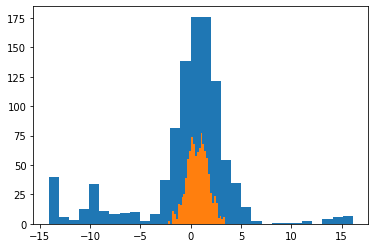

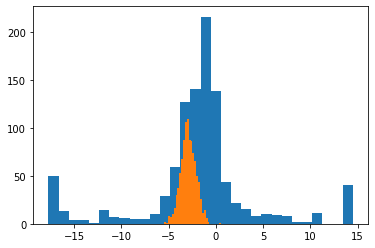

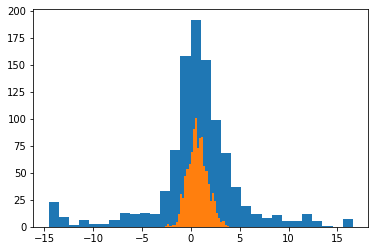

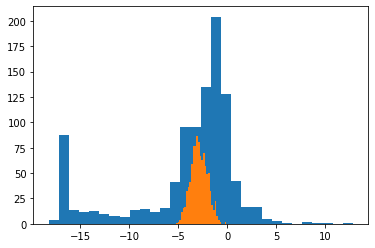

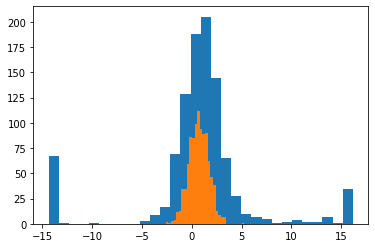

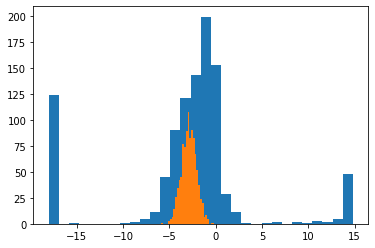

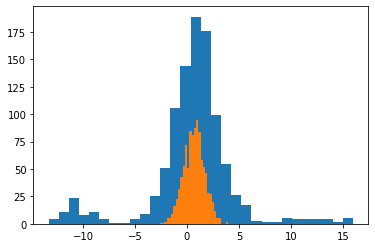

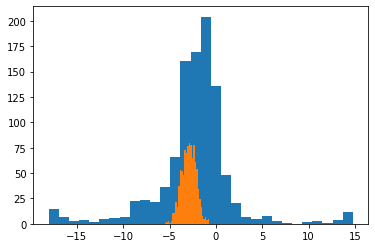

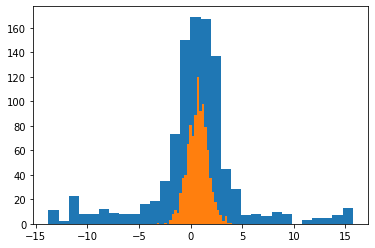

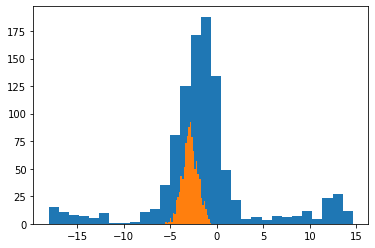

In [ ]:
for i in range(10):
  plt.hist((flow_sample[:, i]*standardisation_params['x_sims_std'][i]) + standardisation_params['x_sims_mean'][i], bins=30)
  plt.hist(true_samples[:, i], bins=30)
  plt.show()

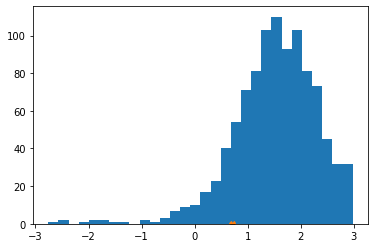

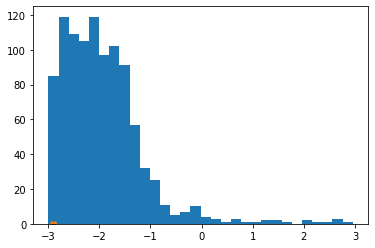

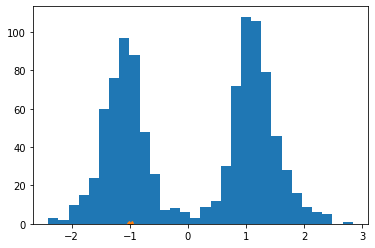

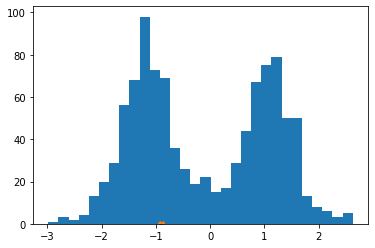

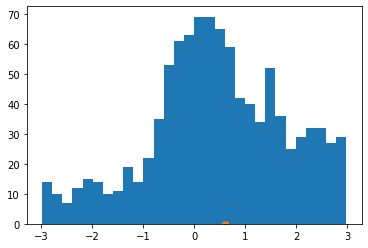

In [ ]:
for i in range(5):
  plt.hist(thetas[:, i], bins=30)
  plt.plot(true_params[i], 0, marker='X')
  plt.show()

In [ ]:
x_obs_standard

DeviceArray([ -0.16022365,  -0.17292055,   0.39638847,   0.08254479,
               0.6227882 ,  -0.507495  ,   0.1638044 ,  -0.6981369 ,
             -57.715107  , -23.532932  ], dtype=float32)

In [ ]:
# SAMPLE FINAL POSTERIOR
nuts_kernel = NUTS(model,
                #    dense_mass=True,
                   target_accept_prob=0.95) #, target_accept_prob=0.95)
mcmc = MCMC(nuts_kernel, num_warmup=2500, num_samples=25000, thinning=1, num_chains=num_chains)  # TODO: MADE NUMBERS UP
key, subkey1, subkey2 = random.split(key, 3)
laplace_var = 0.3 * jnp.abs(x_obs_standard)
mcmc.run(subkey1, x_obs_standard, prior, density_estimator=flow, standardisation_params=standardisation_params,
         laplace_var=laplace_var,
         init_params=init_params,
         key=subkey2)


  0%|          | 0/27500 [00:00<?, ?it/s]

  0%|          | 0/27500 [00:00<?, ?it/s]

  0%|          | 0/27500 [00:00<?, ?it/s]

  0%|          | 0/27500 [00:00<?, ?it/s]

(array([1.0000e+00, 4.0000e+00, 3.0000e+00, 1.1000e+01, 2.6000e+01,
        6.6000e+01, 1.3700e+02, 2.1100e+02, 4.2800e+02, 6.2900e+02,
        9.2400e+02, 1.2020e+03, 1.5920e+03, 2.3620e+03, 3.6380e+03,
        6.1140e+03, 1.2229e+04, 2.2857e+04, 2.7177e+04, 1.2110e+04,
        5.4250e+03, 1.7730e+03, 6.0900e+02, 2.7900e+02, 1.1600e+02,
        5.1000e+01, 1.5000e+01, 7.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([-0.6206429 , -0.5866665 , -0.5526902 , -0.51871383, -0.48473746,
        -0.4507611 , -0.41678473, -0.3828084 , -0.34883204, -0.31485566,
        -0.28087932, -0.24690294, -0.2129266 , -0.17895024, -0.14497387,
        -0.11099751, -0.07702115, -0.04304479, -0.00906844,  0.02490792,
         0.05888428,  0.09286064,  0.126837  ,  0.16081336,  0.19478972,
         0.22876608,  0.26274243,  0.2967188 ,  0.33069515,  0.36467153,
         0.39864787], dtype=float32),
 <a list of 30 Patch objects>)

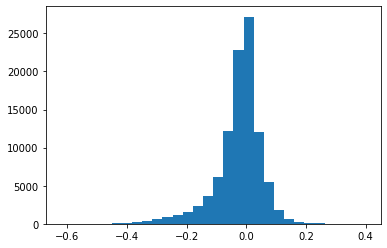

In [ ]:
plt.hist(jnp.squeeze(mcmc.get_samples()['adj_params'][:, 0]), bins=30)

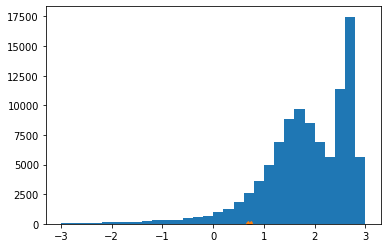

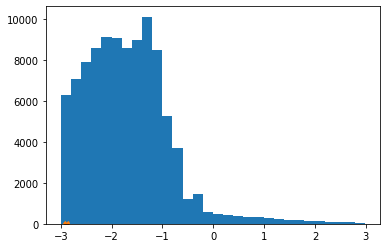

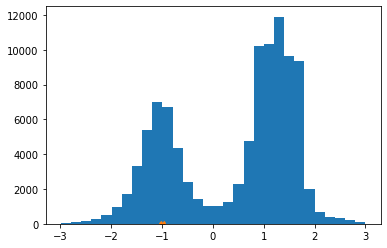

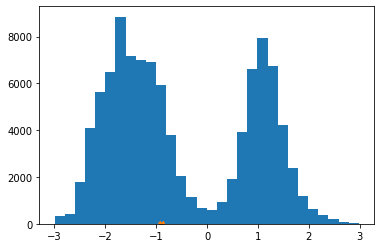

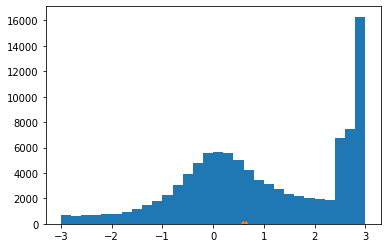

In [ ]:
for i in range(5):
  plt.hist(mcmc.get_samples()['theta'][:, i], bins=30)
  plt.plot(true_params[i], 0, marker='X')
  plt.show()

In [ ]:
key, subkey = random.split(key)
# numpyro.render_model(model, model_args=(x_obs, prior, flow, subkey), render_distributions=True)

In [ ]:
toc = time.time()

print("time: ", toc - tic)

time:  12063.928895235062


In [ ]:
mcmc.print_summary()  


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.03      0.08     -0.01     -0.15      0.09     84.63      1.03
adj_params[1]     -0.00      0.07     -0.00     -0.11      0.11    859.31      1.00
adj_params[2]      0.04      0.17      0.02     -0.24      0.30     69.53      1.04
adj_params[3]      0.01      0.04      0.00     -0.06      0.07    209.05      1.02
adj_params[4]      0.17      0.23      0.14     -0.15      0.57     47.64      1.06
adj_params[5]     -0.13      0.21     -0.10     -0.53      0.14    193.46      1.02
adj_params[6]      0.01      0.08      0.00     -0.11      0.12    100.25      1.04
adj_params[7]     -0.21      0.26     -0.17     -0.68      0.13    132.89      1.03
adj_params[8]    -56.58      2.29    -57.74    -58.36    -52.65      2.08      4.71
adj_params[9]    -23.43      0.82    -23.38    -24.70    -22.07     59.82      1.02
     theta[0]      1.83      0.89      1.93      0.69      2.91      5.88  

In [ ]:
import arviz as az
# az.style.use("arviz-doc")

In [ ]:
inference_data = az.from_numpyro(mcmc)

In [ ]:
folder_name = "vis/rsnl_slcp"

In [ ]:
import os
isExist = os.path.exists(folder_name)
if not isExist:
  os.makedirs(folder_name)

/usr/local/lib/python3.8/dist-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (30), generating only 20 plots
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (120) in plot_autocorr, generating only 40 plots
  warnings.warn(


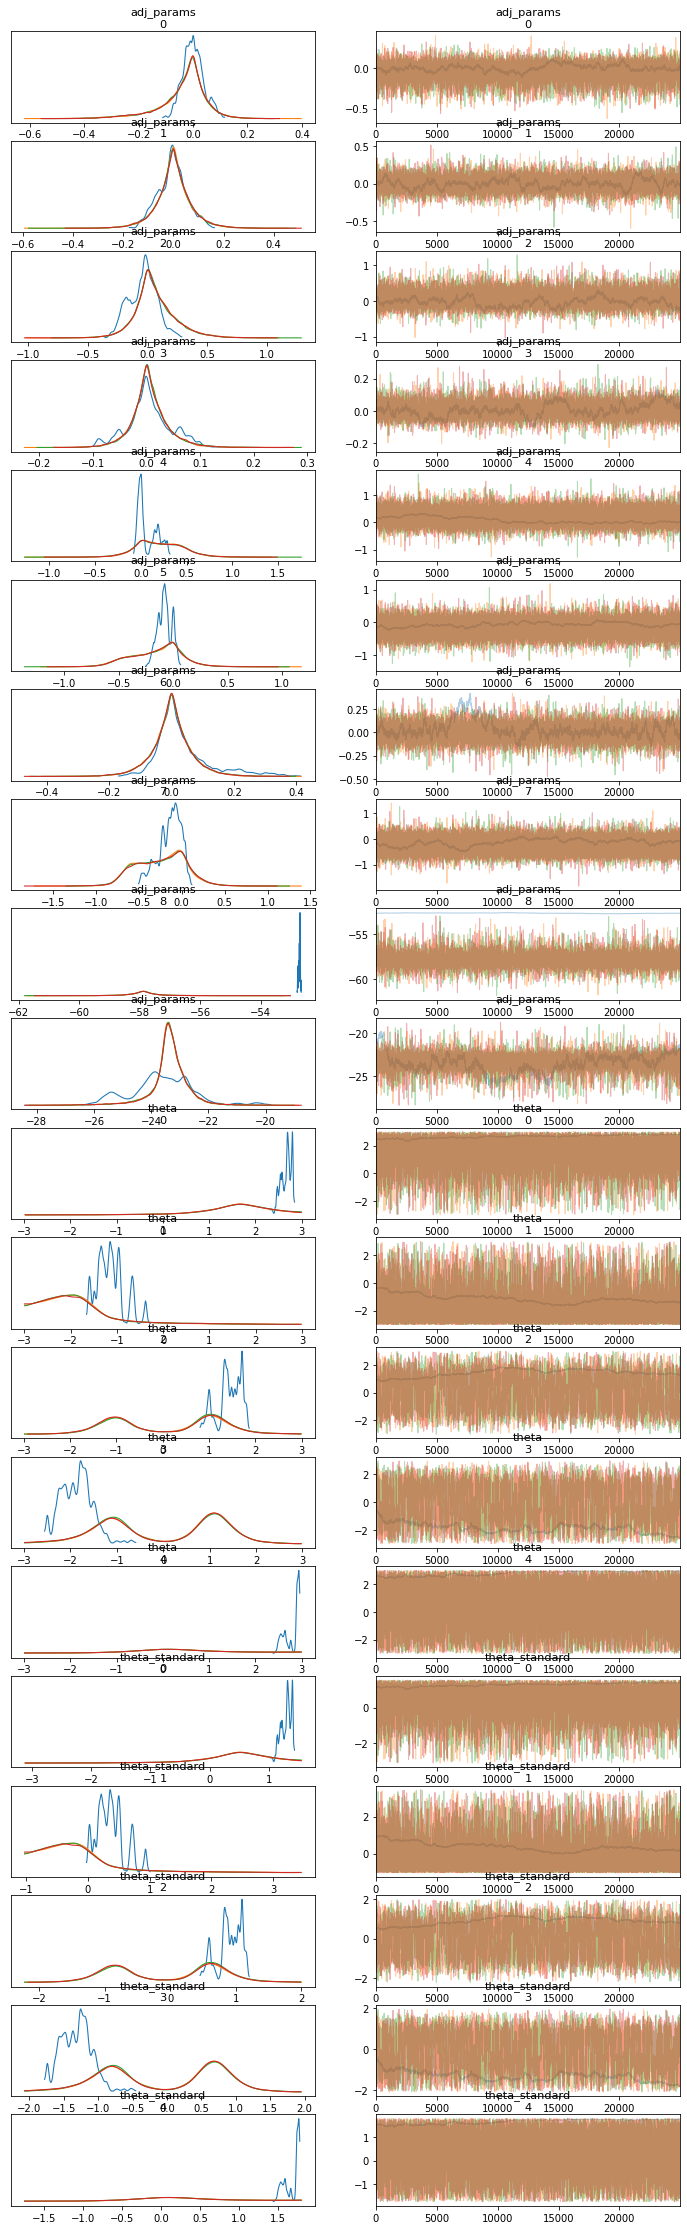

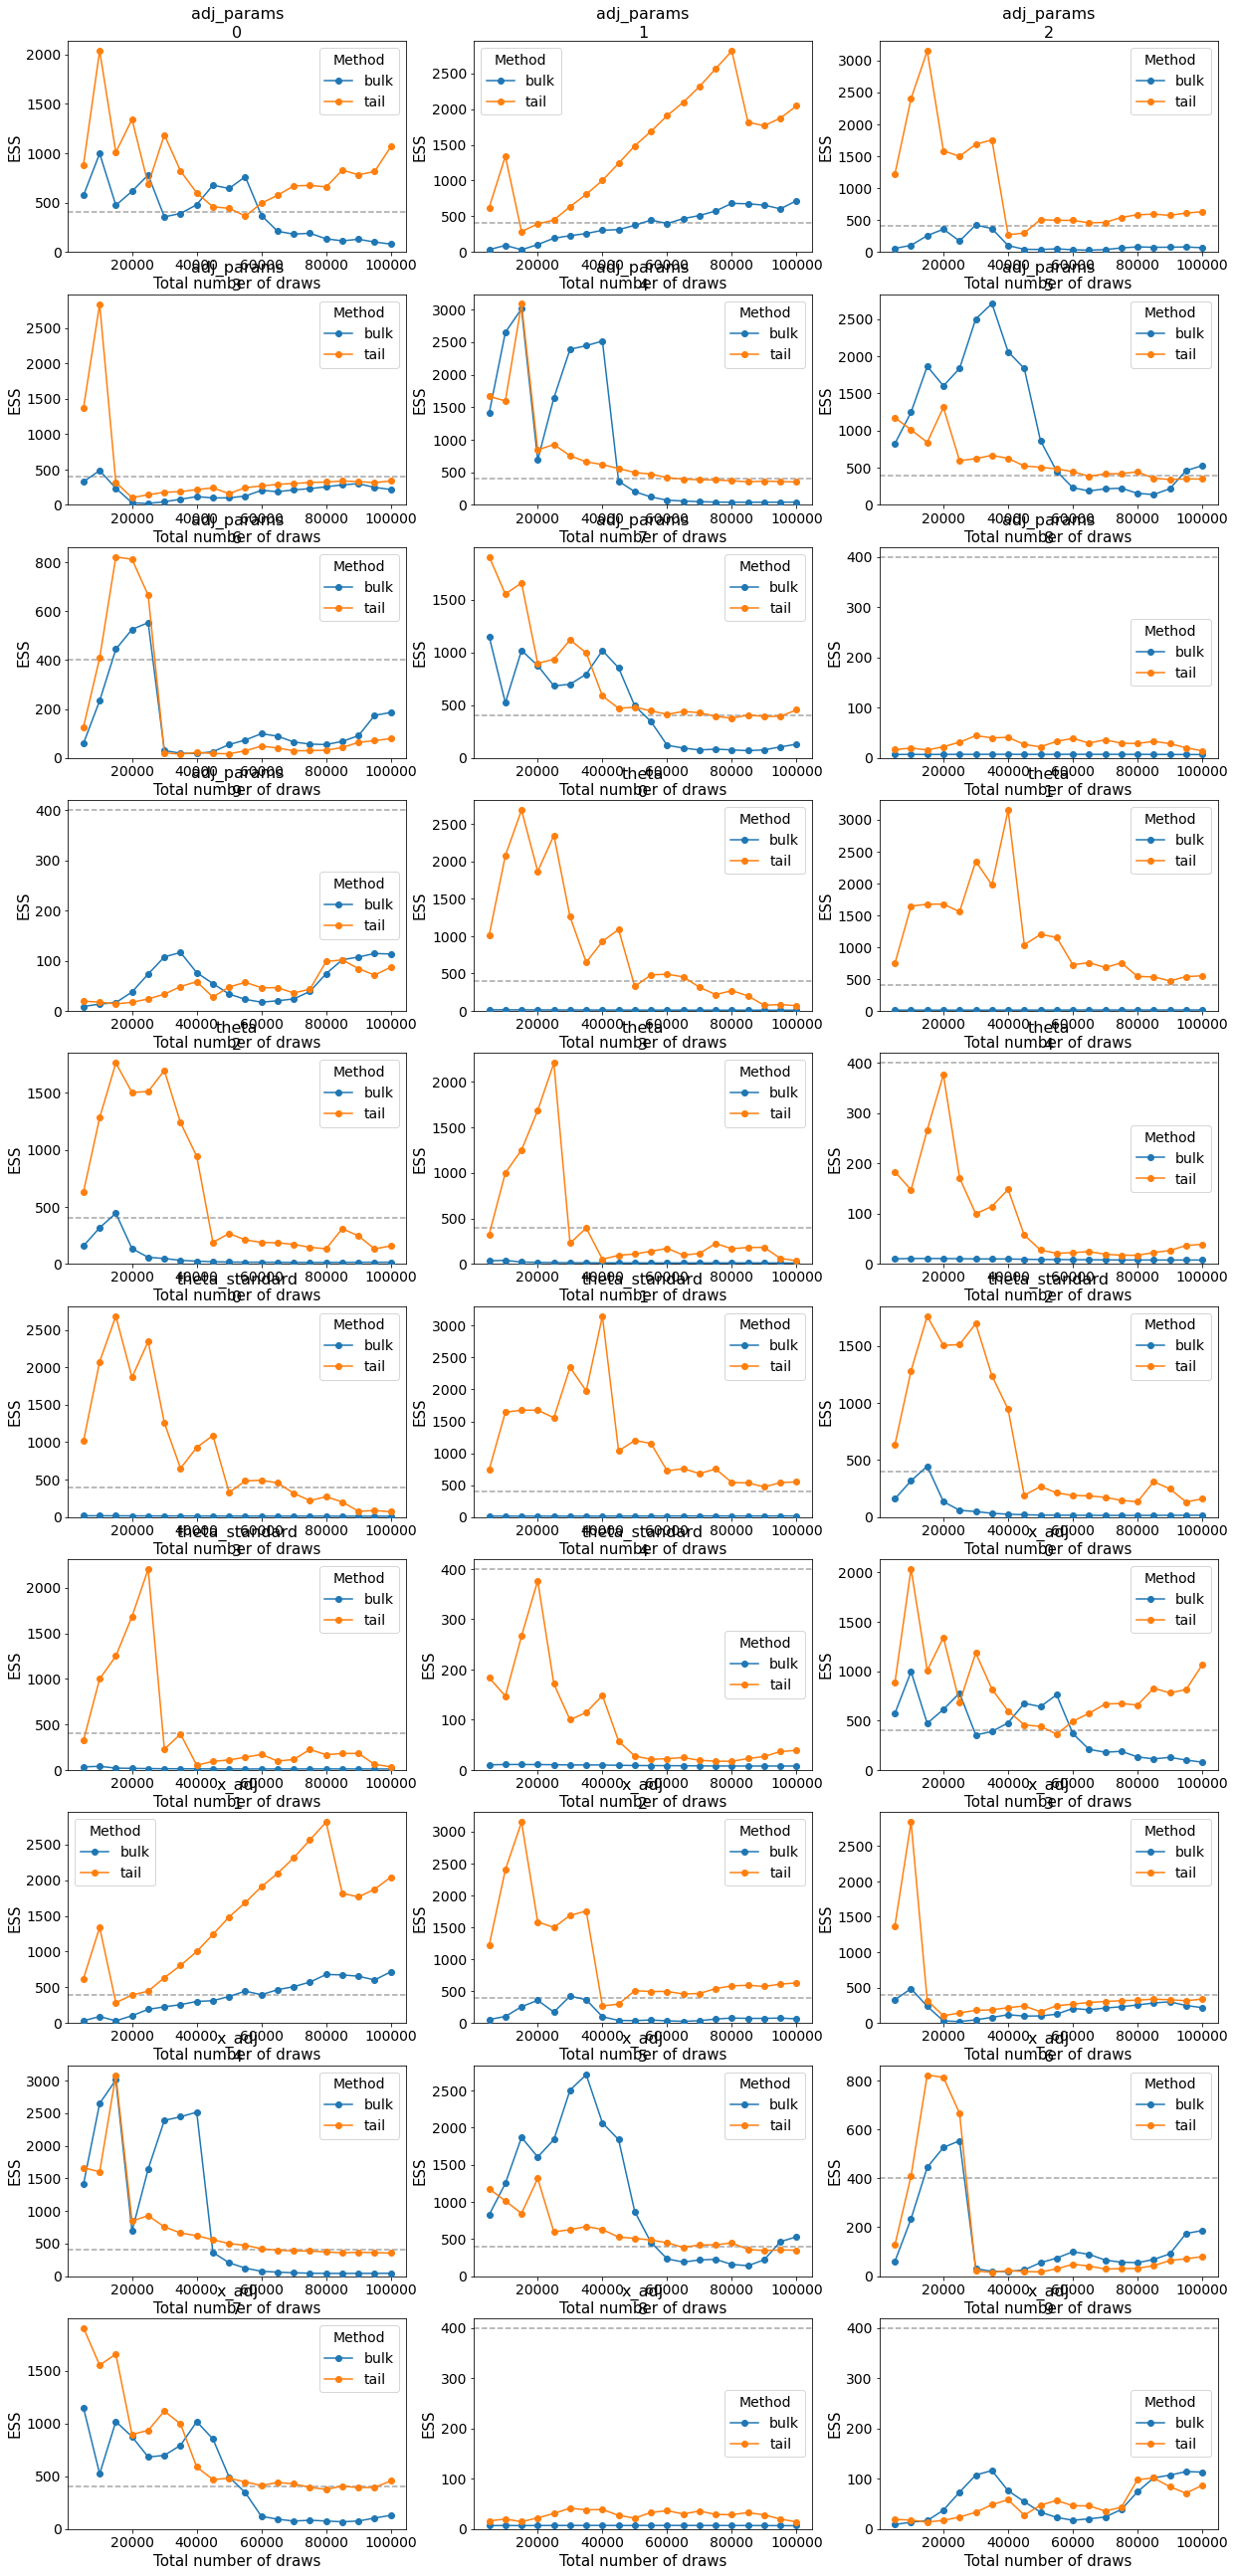

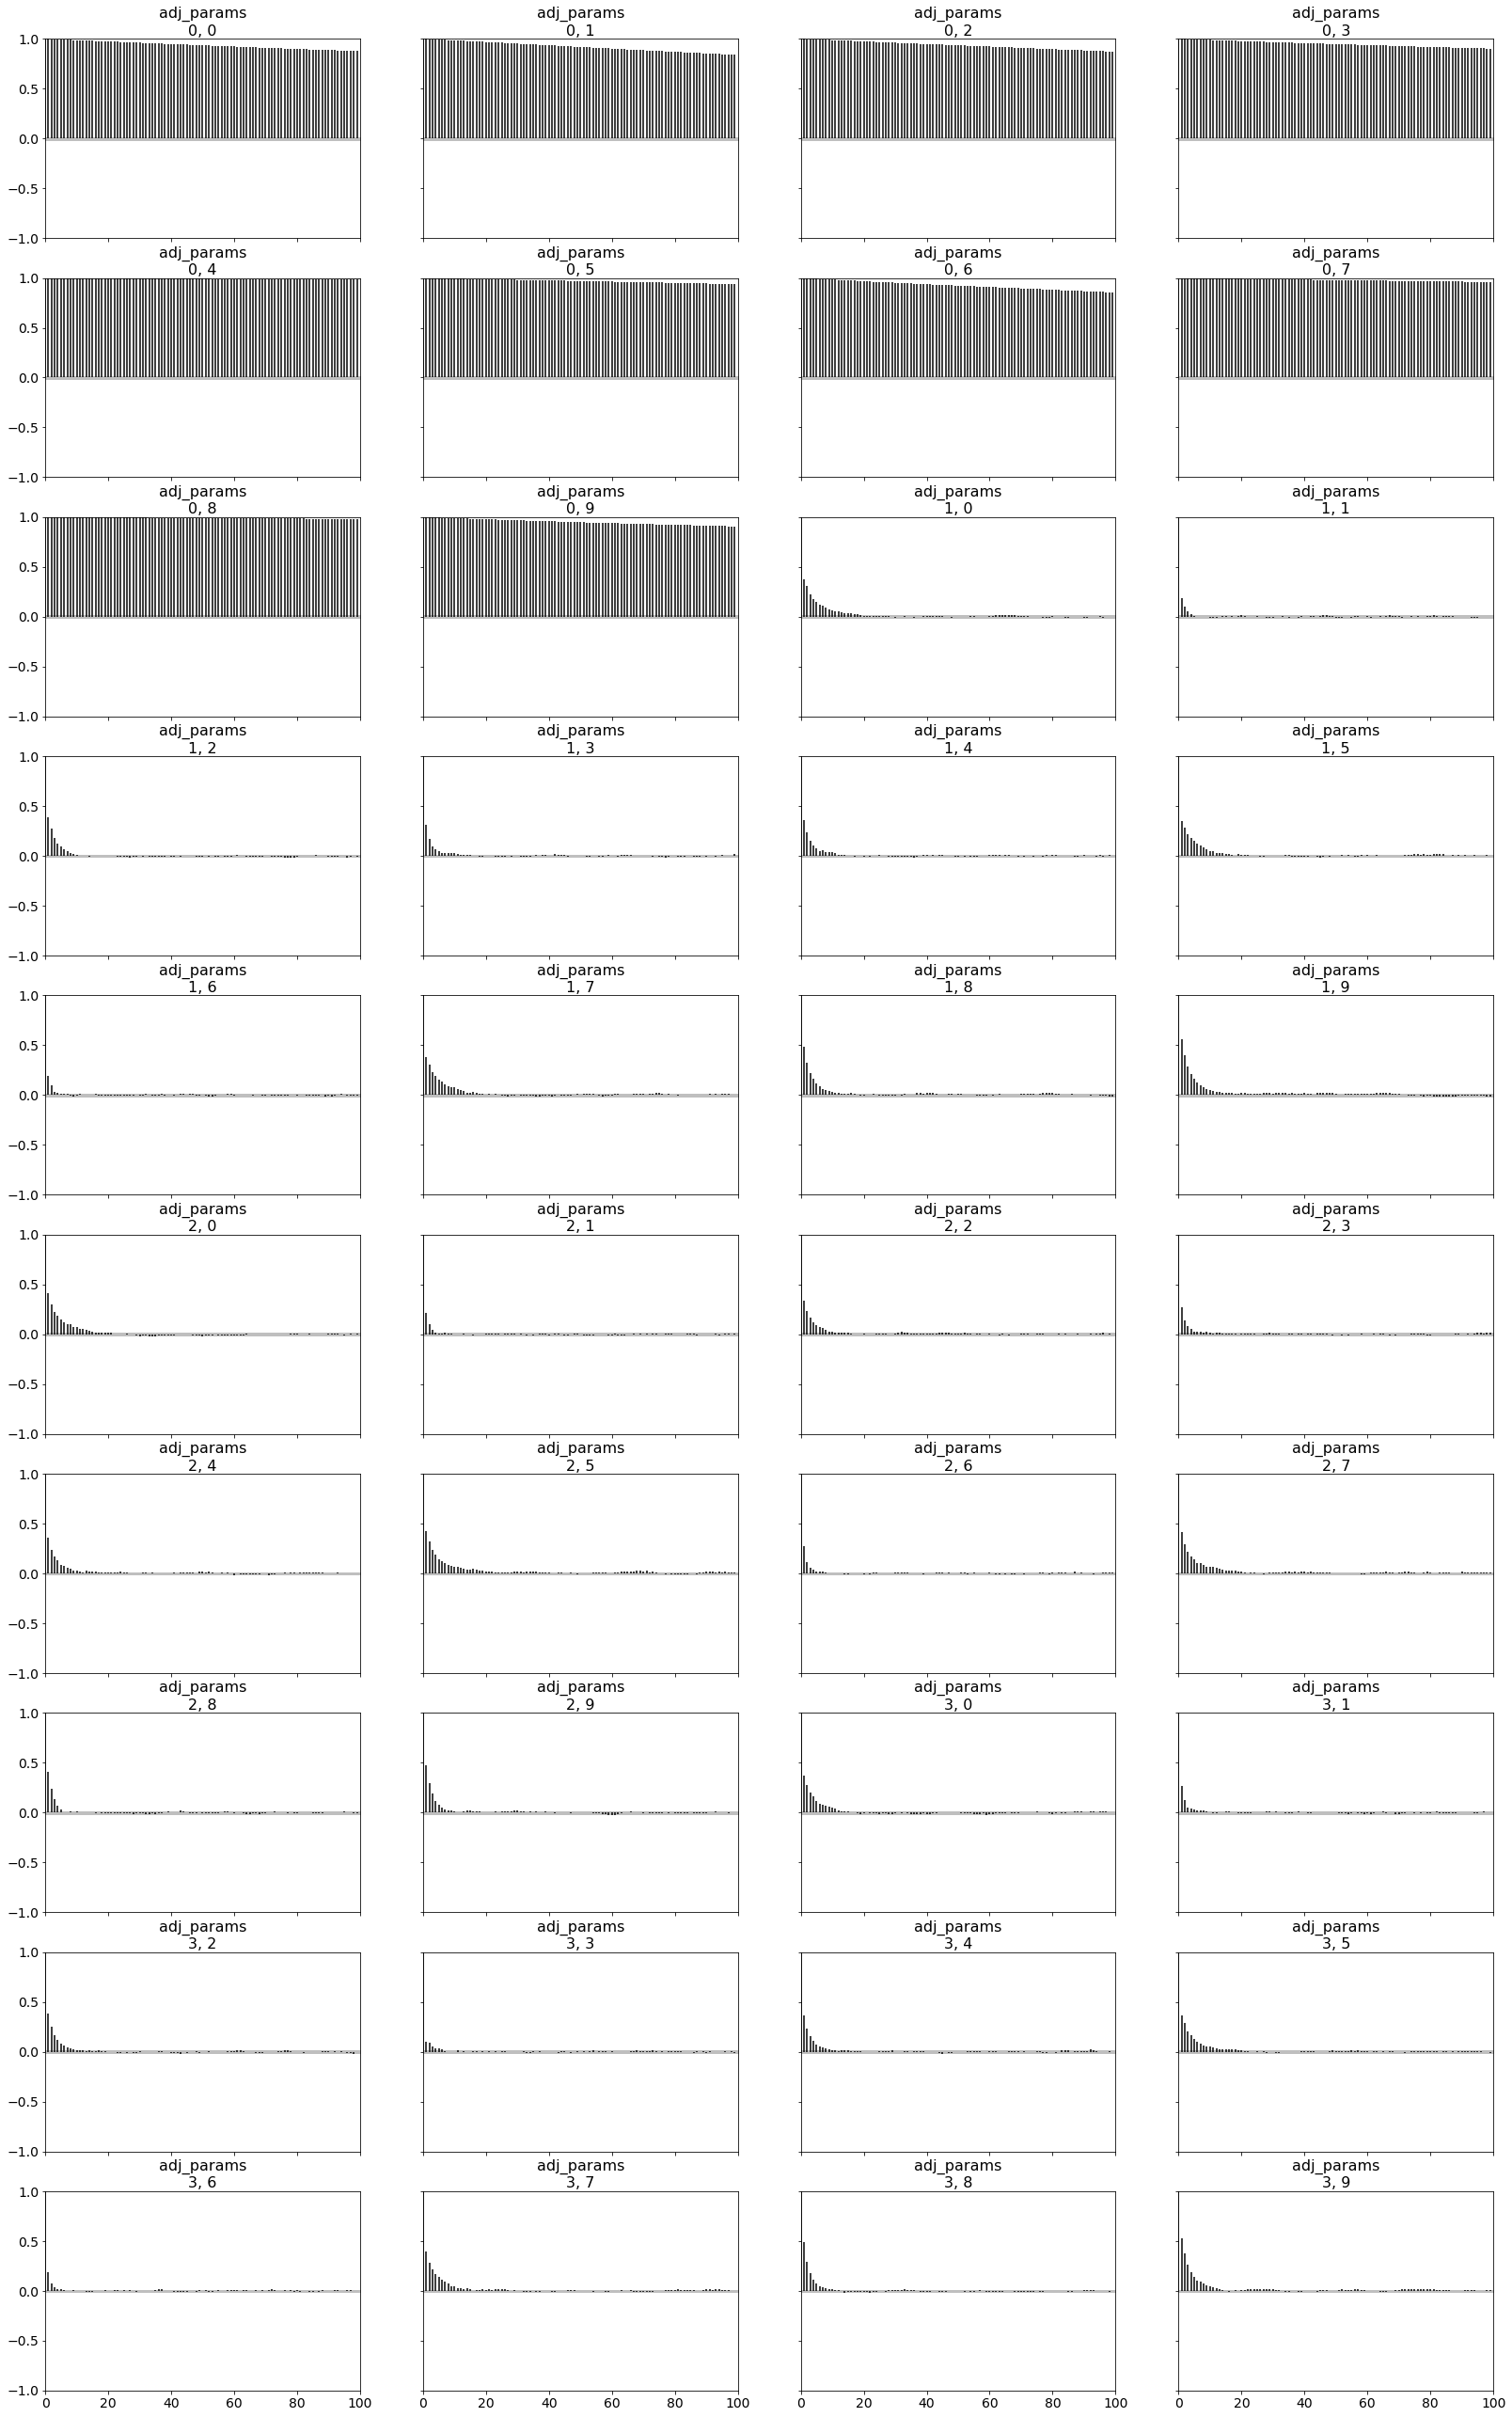

In [ ]:
az.plot_trace(inference_data, compact=False);
plt.savefig(f"{folder_name}_traceplots.png")
az.plot_ess(inference_data, kind="evolution");
plt.savefig(f"{folder_name}_ess_plots.png")
az.plot_autocorr(inference_data);
plt.savefig(f"{folder_name}_autocorr.png")


In [ ]:
import pickle as pkl
import arviz as az
with open('rsnl_slcp_thetas.pkl', 'rb') as f:
    rsnl_data = pkl.load(f)

In [ ]:
import pickle as pkl
import arviz as az
with open('snl_slcp_thetas_correct.pkl', 'rb') as f:
    snl_correct_data = pkl.load(f)

In [ ]:
import pickle as pkl
import arviz as az
with open('snl_slcp_thetas_misspec.pkl', 'rb') as f:
    snl_misspec_data = pkl.load(f)

In [ ]:
rsnl_theta_plot = {}
snl_correct_theta_plot = {}
snl_misspec_theta_plot = {}

for i in range(5):
    rsnl_theta_plot['theta' + str(i+1)] = rsnl_data[1:, :, i].values.flatten()
    snl_correct_theta_plot['theta' + str(i+1)] = snl_correct_data[:, :, i].values.flatten()
    snl_misspec_theta_plot['theta' + str(i+1)] = snl_misspec_data[:, :, i].values.flatten()

var_name_map = {}
reference_values = {}
for ii, k in enumerate(rsnl_theta_plot):
    var_name_map[k] = fr'$\{k[:-1]}_{k[-1]}$'
    reference_values[var_name_map[k]] = true_params[ii]  # why does ref_vals match labels and not data? ah well

In [ ]:
# rsnl_theta_plot['theta1'].shape

(7500,)

In [ ]:
import seaborn as sns
import pandas as pd

TypeError: ignored

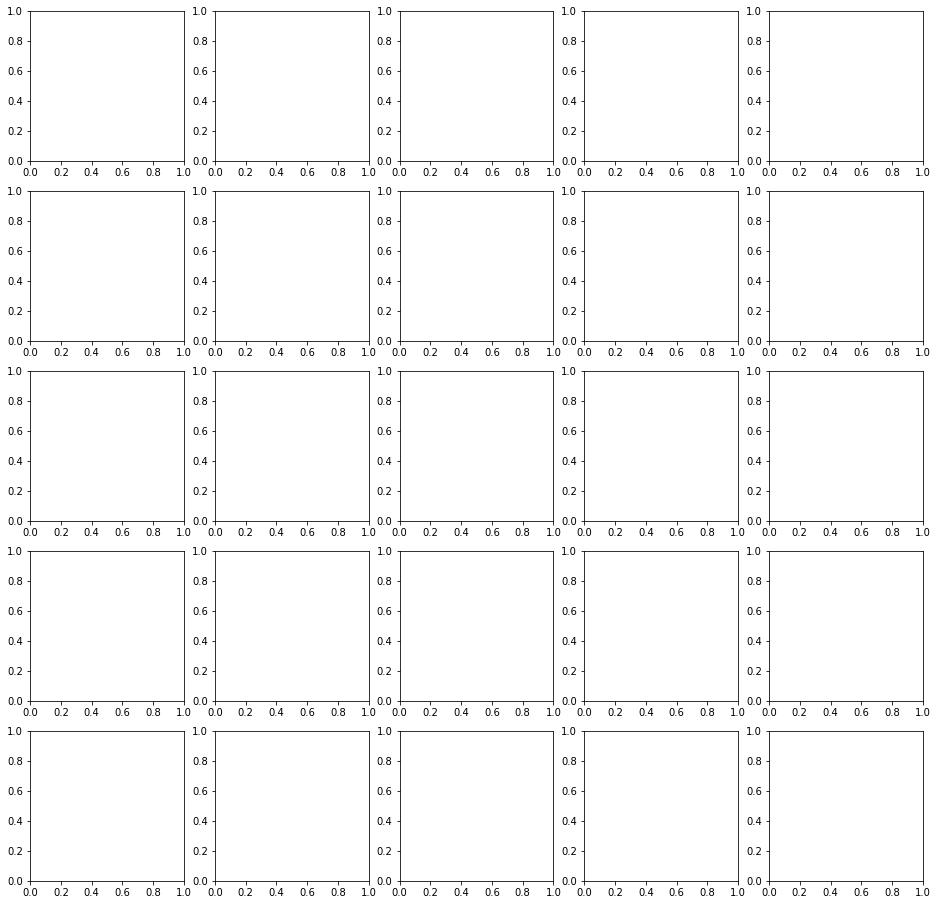

In [ ]:
rsnl_theta_plot_df = pd.DataFrame.from_dict(rsnl_theta_plot)
snl_correct_theta_plot_df = pd.DataFrame.from_dict(snl_correct_theta_plot)


# fig, axes = plt.subplots(5, 5, sharey=False, figsize=(16, 16))

sns.pairplot(data=rsnl_theta_plot_df, kind='kde', corner=True, ax=axes)
sns.pairplot(data=snl_correct_theta_plot_df, kind='kde', corner=True, ax=axes)

jj
jj
jj
jj
jj
jj
jj
jj
jj
jj


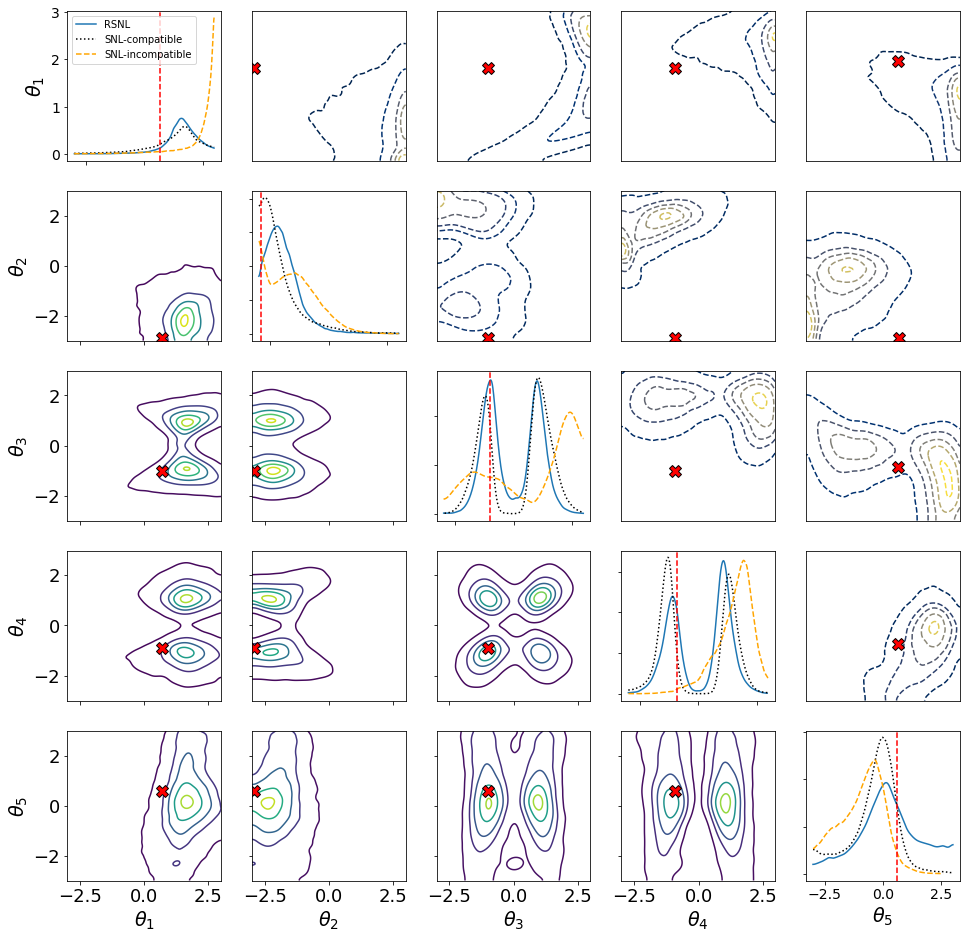

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde as kde
# fig = plt.figure()
fig, axes = plt.subplots(5, 5, sharey=False, figsize=(16, 16))
# fig2, axes2 = plt.subplots(5, 5, sharey=False, figsize=(16, 16))

# fig, axes = plt.subplots(4, 4)
# original_backend = plt.rcParams["backend"]
old_axes = np.empty((5, 5), dtype='object')
for i in range(5):
    for j in range(5):
        old_axes[i][j] = axes[i][j].axes
axes = az.plot_pair(rsnl_theta_plot,
                    kind='kde',
                    reference_values=reference_values,
                    reference_values_kwargs={'color': 'red', 'marker': 'X', 'markersize': 12},
                    kde_kwargs={'hdi_probs': [0.05, 0.25, 0.5, 0.75, 0.95],
                                'contour_kwargs': {"colors":None, "cmap":plt.cm.viridis},
                                'contourf_kwargs': {"alpha":0}},
                    ax=axes,
                    labeller=az.labels.MapLabeller(var_name_map=var_name_map),
                    textsize=18,
                    marginals=True,
                    marginal_kwargs={'label': 'RSNL'},
                    # show=False
                    # figsize=(64, 64)
                    )


curr_fig = plt.gcf()
for ii, ax_ii in enumerate(axes):
    for jj, ax_jj in enumerate(ax_ii):
        if ii == jj:  # only marginal for now
            # az.plot_density(snl_misspec_theta_plot['theta' + str(ii+1)], ax=ax_jj, colors='orange', point_estimate=None)
            # az.plot_density(snl_correct_theta_plot['theta' + str(ii+1)], ax=ax_jj, colors='black', point_estimate=None)
            # xs = np.arange(-3, 3, 100)
            # kde_jj = kde(snl_correct_theta_plot['theta' + str(ii+1)])
            # ax_jj.plot(xs, kde_jj(xs), color='black')
            az.plot_dist(snl_correct_theta_plot['theta' + str(ii+1)],ax=ax_jj, color='black', plot_kwargs={'linestyle': 'dotted'}, label='SNL-compatible')
            az.plot_dist(snl_misspec_theta_plot['theta' + str(ii+1)],ax=ax_jj, color='orange', plot_kwargs={'linestyle': 'dashed'}, label='SNL-incompatible')
            if ii != 0:
                ax_jj.get_legend().remove()
            ax_jj.axvline(x=true_params[jj], color='red', linestyle='dashed')
        if ii < jj:
            print('jj')
            # fig.add_subplot()
            ax_jj._remove_method = None
            ax_jj.figure = curr_fig
            # ax_jj.set_visible(True)
            # ax_jj.axis('on')
            ax_jj = az.plot_kde(snl_misspec_theta_plot['theta' + str(ii+1)],
                                snl_misspec_theta_plot['theta' + str(jj+1)],
                                ax=ax_jj,
                                hdi_probs=[0.05, 0.25, 0.5, 0.75, 0.95],
                                contour_kwargs={"colors": None, "cmap":plt.cm.cividis, 'linestyles': 'dashed'},
                                contourf_kwargs={"alpha":0}, show=False)
            ax_jj.plot(true_params[jj], true_params[ii], color='red', marker= 'X', markersize=12, markeredgecolor='k')
            ax_jj.axes = old_axes[ii, jj]
            ax_jj.axes.get_xaxis().set_visible(False)
            ax_jj.axes.get_yaxis().set_visible(False)
            # ax_jj.set_visible(False)
            fig.add_subplot(ax_jj)
            # plt.add_axes(ax)
            # axes[ii, jj] = ax
        #     axes[ii, jj] = axes2[jj, ii]
            # ax_jj.plot(x=0, y=0)
# plt.axes().get_xaxis().set_visible(True)
# plt.axes().get_yaxis().set_visible(True)

# plt.show()
plt.savefig("rsnl_slcp_joint.pdf", bbox_inches='tight')

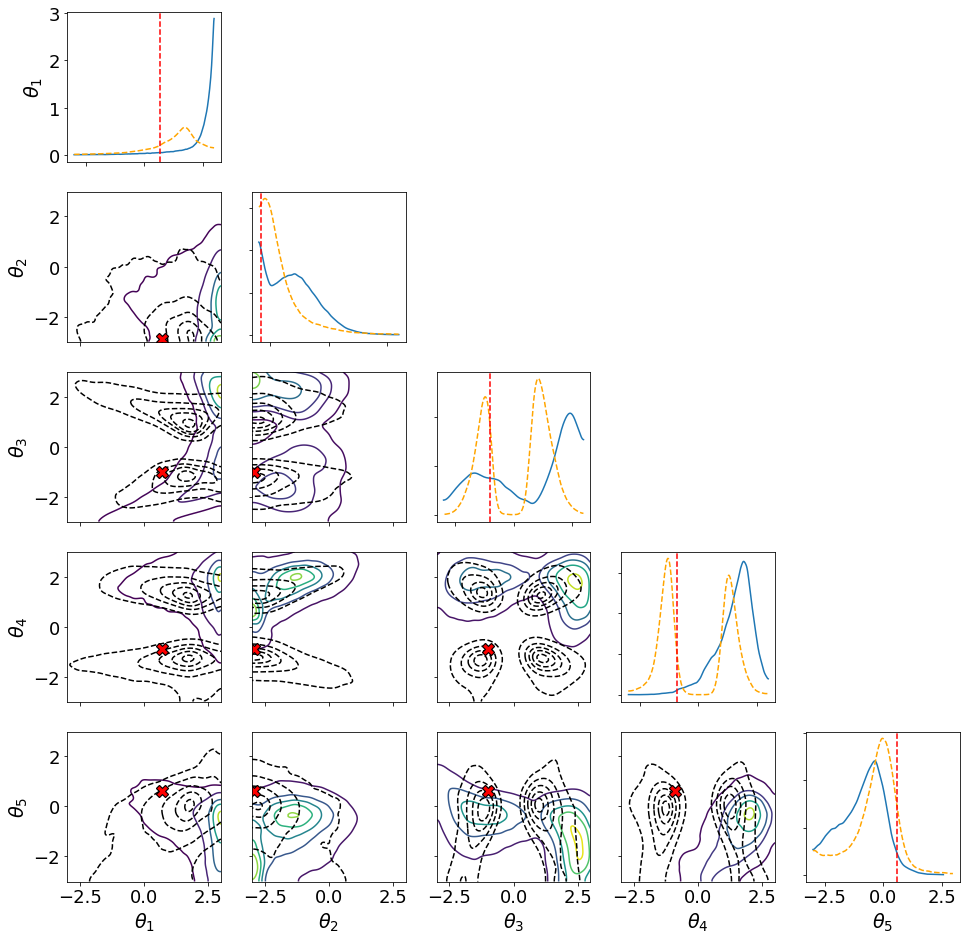

In [ ]:

# fig = plt.figure()
fig, axes = plt.subplots(5, 5, sharey=False, figsize=(16, 16))
# fig2, axes2 = plt.subplots(5, 5, sharey=False, figsize=(16, 16))

# fig, axes = plt.subplots(4, 4)
# original_backend = plt.rcParams["backend"]
axes = az.plot_pair(snl_misspec_theta_plot,
                    kind='kde',
                    reference_values=reference_values,
                    reference_values_kwargs={'color': 'red', 'marker': 'X', 'markersize': 12},
                    kde_kwargs={'hdi_probs': [0.05, 0.25, 0.5, 0.75, 0.95],
                                'contour_kwargs': {"colors":None, "cmap":plt.cm.viridis},
                                'contourf_kwargs': {"alpha":0}},
                    ax=axes,
                    labeller=az.labels.MapLabeller(var_name_map=var_name_map),
                    textsize=18,
                    marginals=True,
                    marginal_kwargs={},
                    # show=False
                    # figsize=(64, 64)
                    )

axes = az.plot_pair(snl_correct_theta_plot,
                    kind='kde',
                    reference_values=reference_values,
                    reference_values_kwargs={'color': 'red', 'marker': 'X', 'markersize': 12},
                    kde_kwargs={'hdi_probs': [0.05, 0.25, 0.5, 0.75, 0.95],
                                'contour_kwargs': {"colors": 'black', 'linestyles': 'dashed'},
                                'contourf_kwargs': {"alpha":0}},
                    ax=axes,
                    labeller=az.labels.MapLabeller(var_name_map=var_name_map),
                    textsize=18,
                    marginals=True,
                    marginal_kwargs={'color': 'orange',
                                     'plot_kwargs': {'linestyle': 'dashed'}},
                    # show=False
                    # figsize=(64, 64)
                    )

# axes.invert_xaxis()


# axes = az.plot_pair(snl_misspec_theta_plot,
#                     kind='kde',
#                     reference_values=reference_values,
#                     reference_values_kwargs={'color': 'red', 'marker': 'X', 'markersize': 12},
#                     kde_kwargs={'hdi_probs': [0.05, 0.25, 0.5, 0.75, 0.95],
#                                 'contour_kwargs': {"colors": 'purple', 'linestyles': 'dashdot'},
#                                 'contourf_kwargs': {"alpha":0}},
#                     ax=axes,
#                     labeller=az.labels.MapLabeller(var_name_map=var_name_map),
#                     textsize=18,
#                     marginals=True,
#                     marginal_kwargs={'color': 'purple',
#                                      'plot_kwargs': {'linestyle': 'dashdot'}}
#                     # figsize=(64, 64)
#                     )

# plt.rcParams.update({'backend': original_backend})

for ii, ax_ii in enumerate(axes):
    for jj, ax_jj in enumerate(ax_ii):
        if ii == jj:  # only marginal for now
            ax_jj.axvline(x=true_params[jj], color='red', linestyle='dashed')
            # az.plot_density(snl_misspec_theta_plot['theta' + str(ii+1)], ax=ax_jj)
        # if ii < jj:
        #     print('jj')
        #     print('ax_jj: ', ax_jj.get_visible())
        #     ax_jj.set_visible(True)
        #     ax_jj.axis('on')
        #     az.plot_kde(snl_misspec_theta_plot['theta' + str(ii+1)], snl_misspec_theta_plot['theta' + str(jj+1)], ax=ax_jj)
            
            # plt.add_axes(ax)
            # axes[ii, jj] = ax
        #     axes[ii, jj] = axes2[jj, ii]
            # ax_jj.plot(x=0, y=0)
# plt.axes().get_xaxis().set_visible(True)
# plt.axes().get_yaxis().set_visible(True)

# plt.show()
plt.savefig("snl_slcp_joint.pdf")

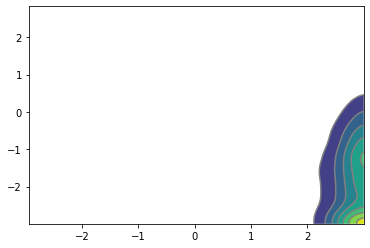

In [ ]:
az.plot_kde(snl_misspec_theta_plot['theta1'], snl_misspec_theta_plot['theta2'])

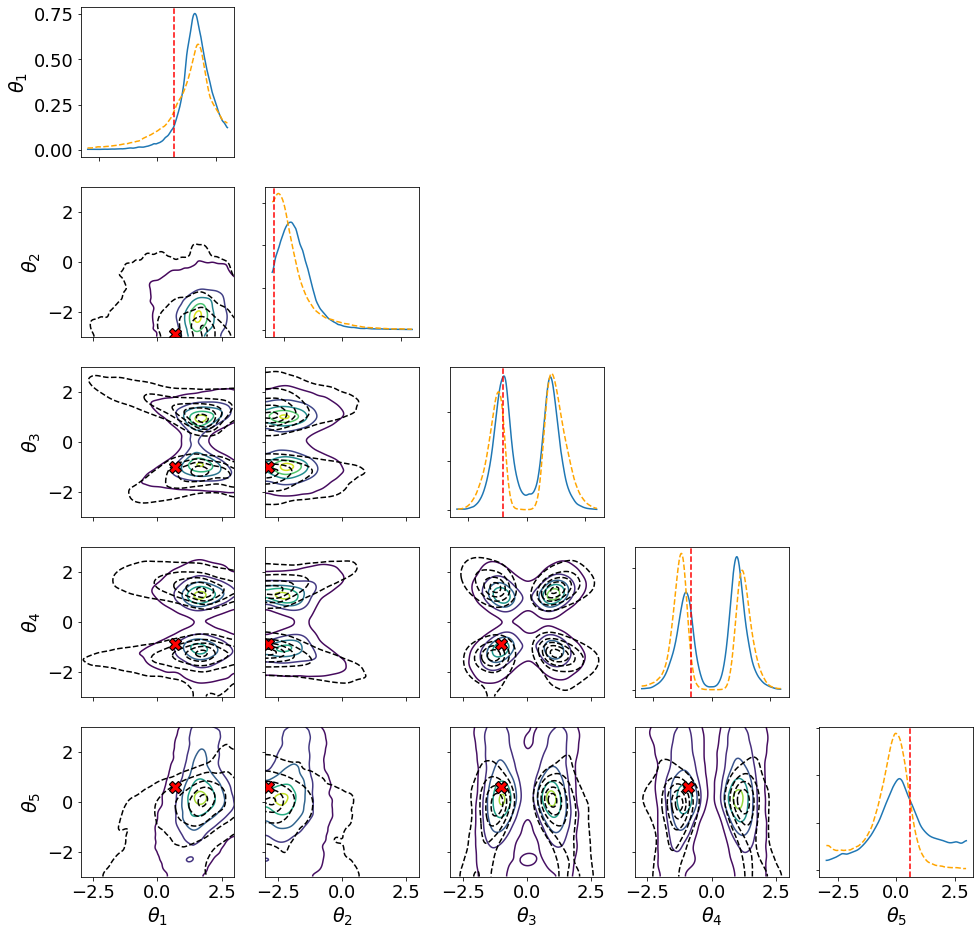

In [ ]:
curr_fig

In [ ]:
from google.colab import files
# plt.savefig("joint_kde.pdf", bbox_inches='tight')
# files.download("joint_kde.pdf")

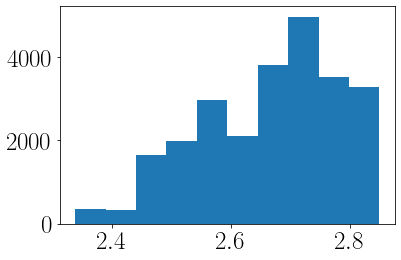

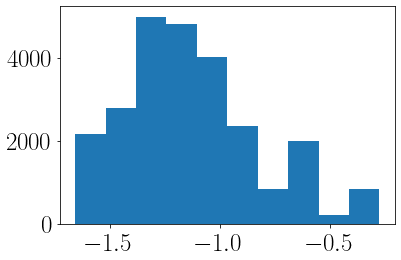

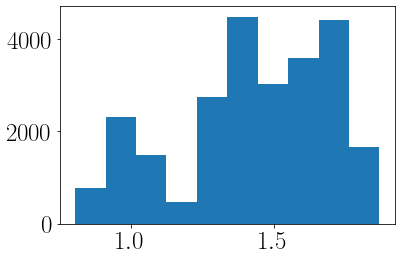

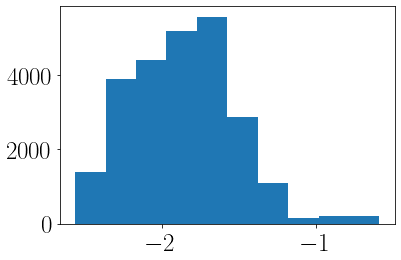

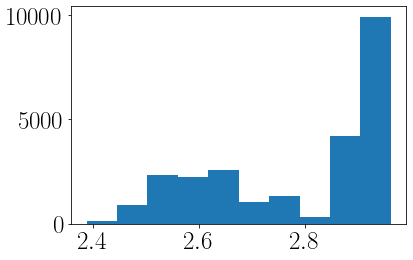

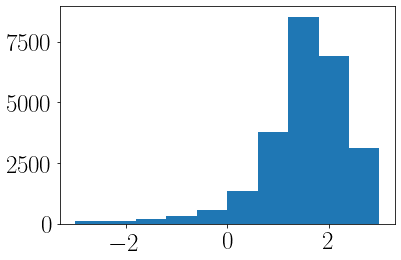

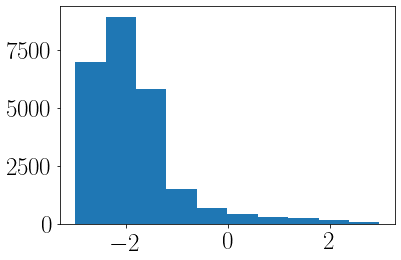

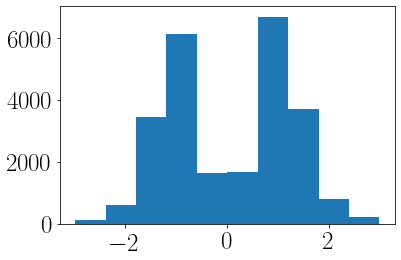

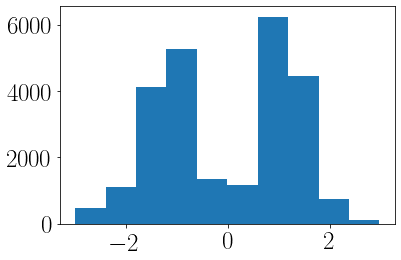

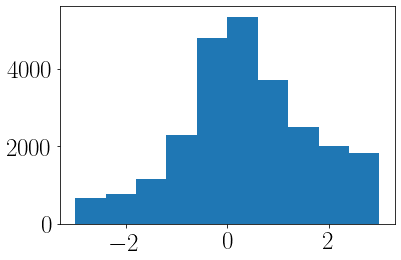

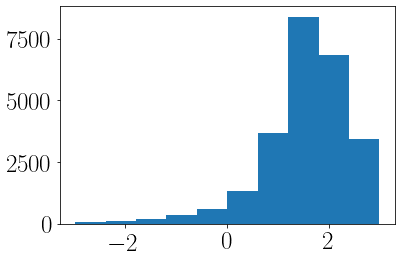

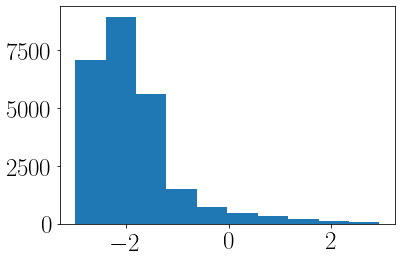

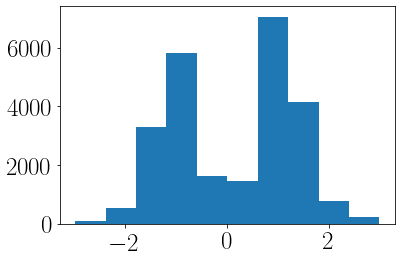

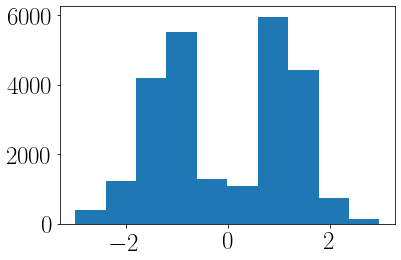

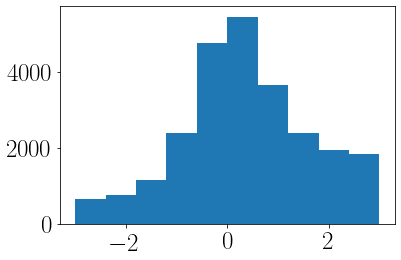

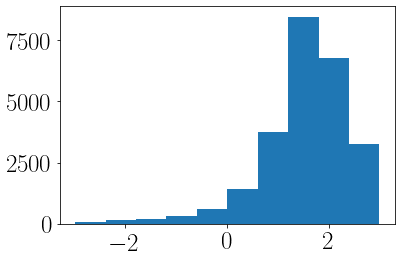

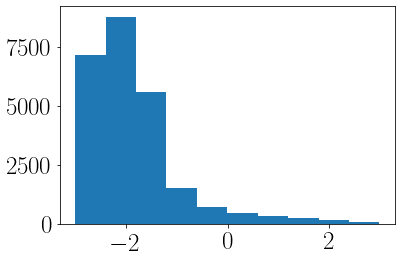

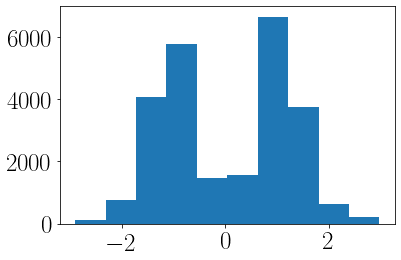

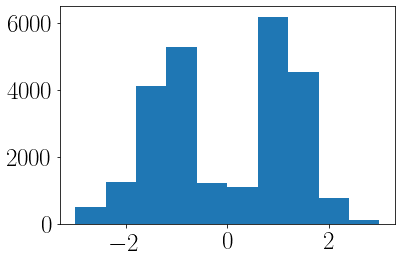

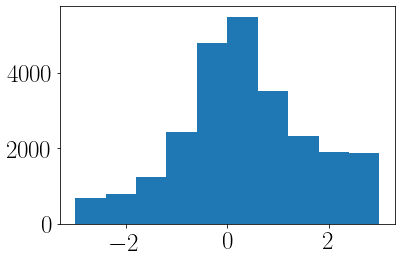

In [ ]:
for i in range(4):
    for j in range(5):
        plt.hist(inference_data.posterior.theta[i, :, j])
        plt.show()

In [ ]:
import numpy as np
import pickle as pkl

with open('rsnl_slcp_thetas.pkl', 'wb') as f: pkl.dump(inference_data.posterior.theta, f)
with open('rsnl_slcp_adj_params.pkl', 'wb') as f: pkl.dump(inference_data.posterior.adj_params, f)

/usr/local/lib/python3.8/dist-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (30), generating only 20 plots
  warnings.warn(


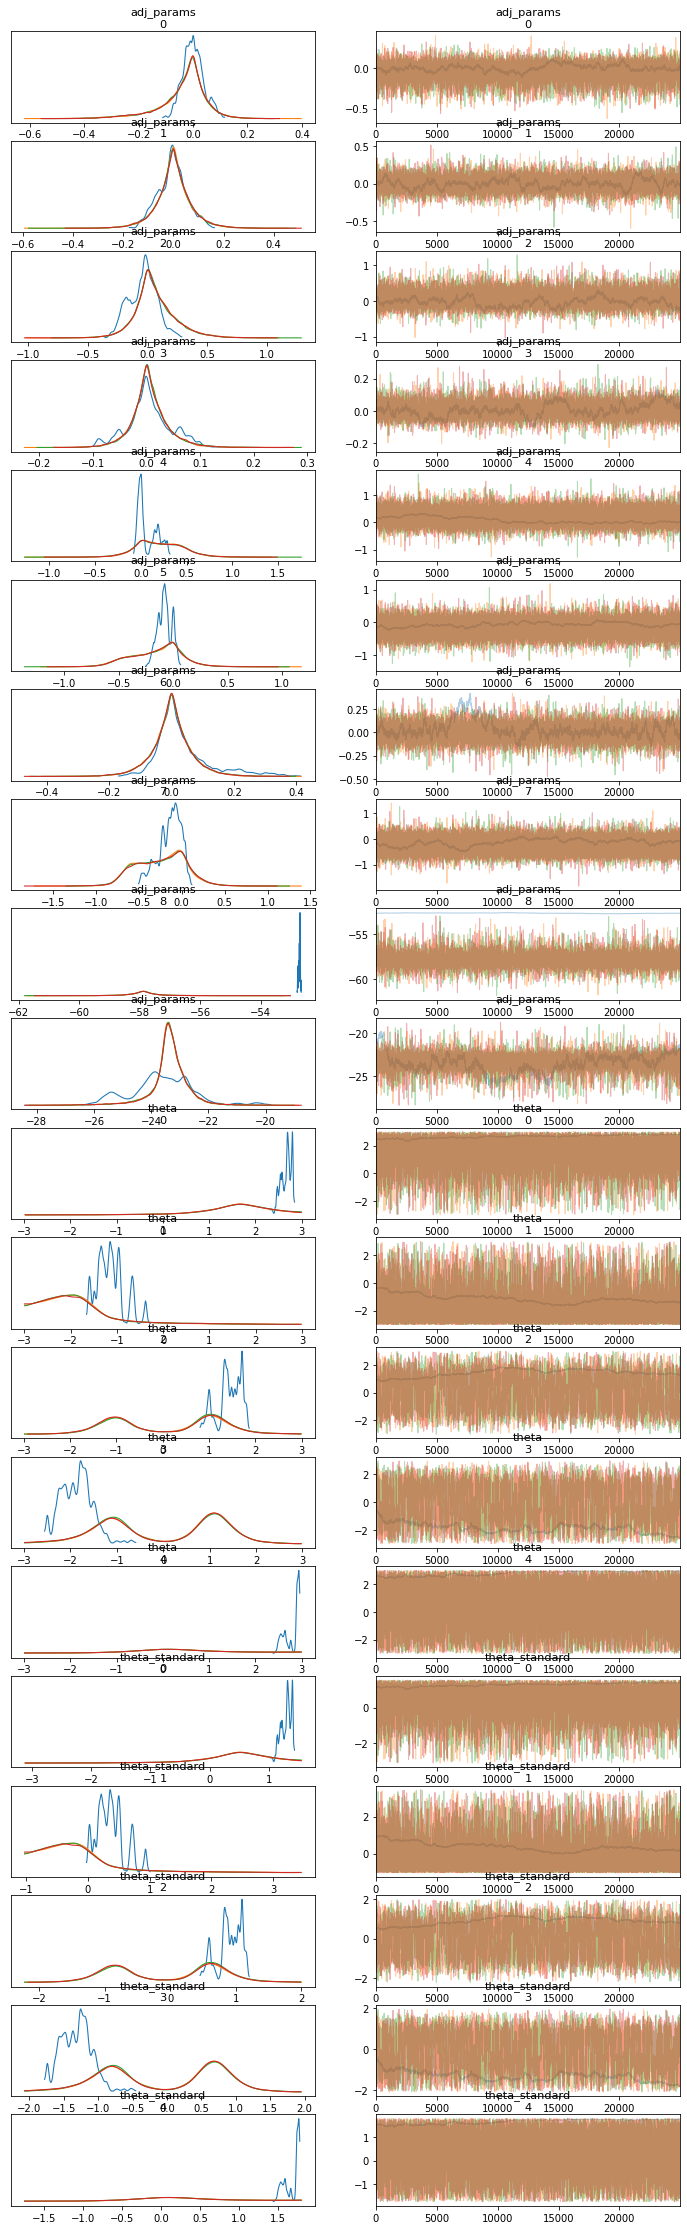

In [ ]:
az.plot_trace(inference_data, compact=False, combined=False);

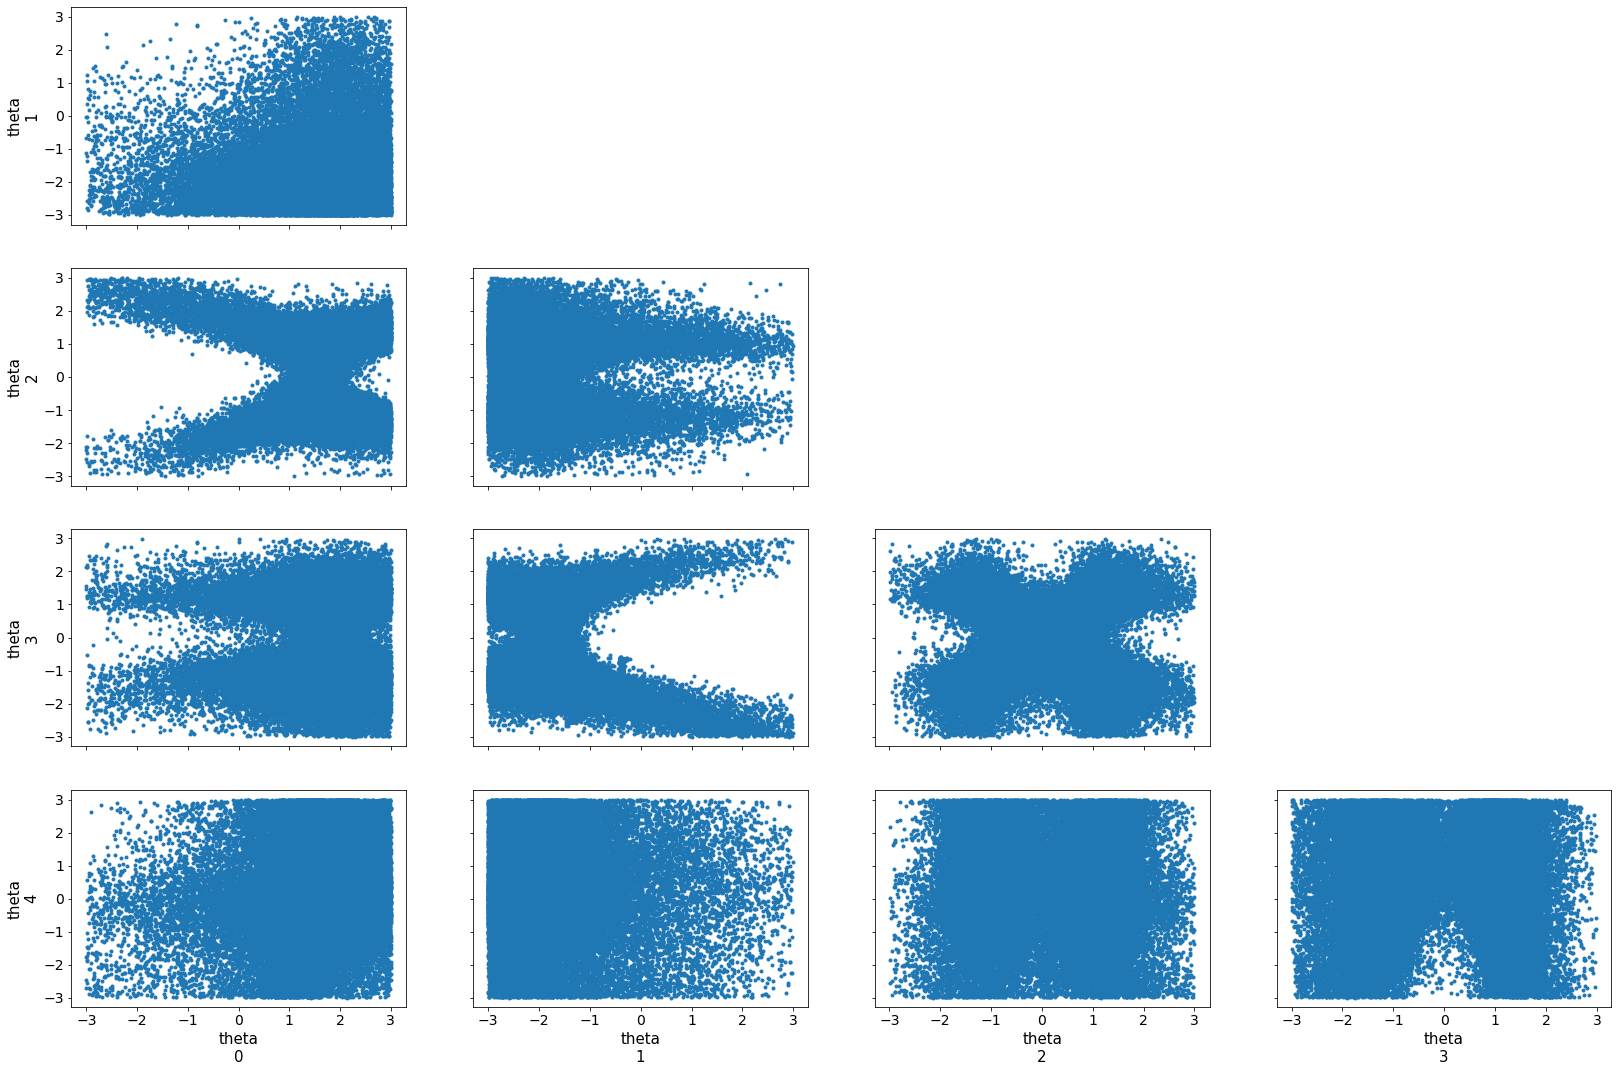

In [ ]:
az.plot_pair(inference_data.posterior.theta);

In [ ]:
!sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super;
!pip install -U latex --quiet;

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript javascript-common
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libgs9 libgs9-common libidn11 libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpdfbox-java libptexenc1 libruby2.7 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb
  poppler-data preview-latex-style rake ruby ruby-minitest ruby-net-telnet
  ruby-power-assert ruby-test-unit ruby-xmlrpc ruby2.7 rubygems-integration
  t1utils tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf g

In [ ]:
import pickle as pkl
import arviz as az
with open('rsnl_slcp_adj_params.pkl', 'rb') as f:
    data = pkl.load(f)


In [ ]:
x_obs_standard = jnp.array([ -0.16022365,  -0.17292055,   0.39638847,   0.08254479,
               0.6227882 ,  -0.507495  ,   0.1638044 ,  -0.6981369 ,
             -57.715107  , -23.532932  ])

In [ ]:
 laplace_mean = jnp.zeros(10)
 laplace_var = 0.3 * jnp.abs(x_obs_standard)
 key = random.PRNGKey(1)
 key, subkey = random.split(key)

 prior_samples = dist.Laplace(laplace_mean, laplace_var).sample(subkey, (10000,))

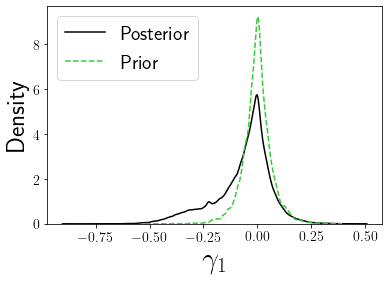

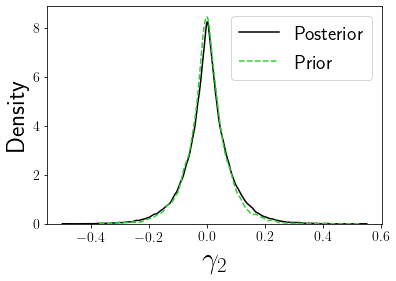

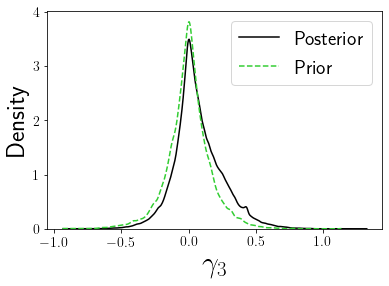

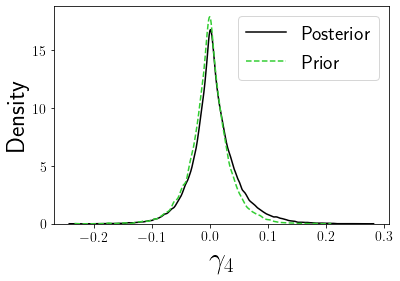

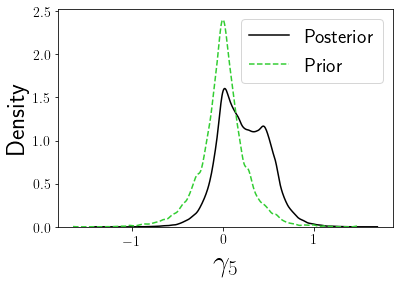

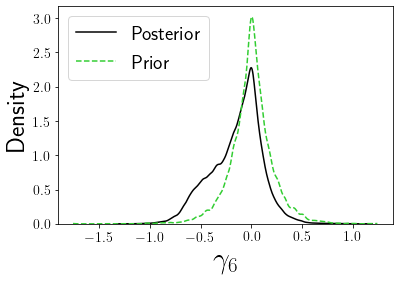

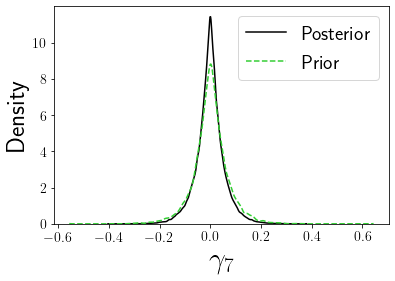

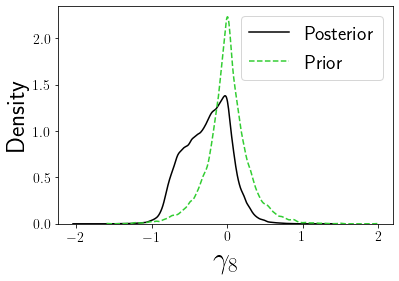

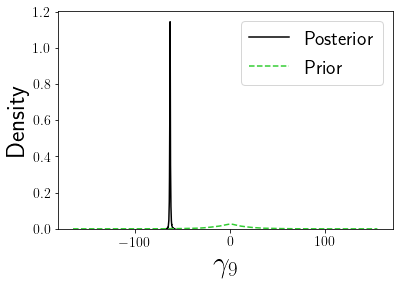

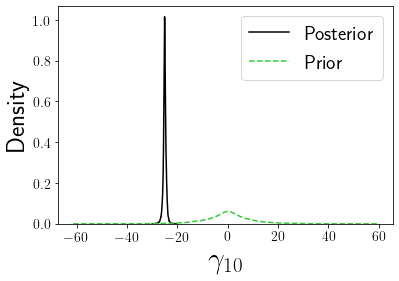

In [ ]:
import matplotlib.colors as mcolors

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 25})

for i in range(10):  # lazy
    az.plot_dist(data[1:, :, i].values.flatten(),  # TODO: CHANGED
                label='Posterior',
                 color='black')
    az.plot_dist(prior_samples[:, i], 
                 color=mcolors.CSS4_COLORS['limegreen'],
                 plot_kwargs={'linestyle': 'dashed'},
                 label='Prior')
    # subscript = i + 1
    plt.xlabel("$\gamma_{%s}$" % (i+1), fontsize=30)
    plt.ylabel("Density", fontsize=25)
    plt.ylim(bottom=0)
    plt.legend(fontsize=20)
    # plt.title("$b_0 = 0.01$")
    plt.savefig(f'slcp_adj_param{i+1}.pdf', bbox_inches='tight')
    plt.show()
